In [1]:
import torch.nn as nn
import torch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from data.dataloader import data_generator, data_generator_2types
from models.losses import loss_function

In [4]:
from models.gru_denoiser import BiGRUSpectralDenoiser

## NN

In [5]:
model = BiGRUSpectralDenoiser(hidden_size=512) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

### Training loop

In [6]:
from training.trainer import Trainer

In [7]:
trainer = Trainer(
    model=model, loss_function=loss_function, data_generator=data_generator, lr = 5e-4, weight_decay=1e-6,
    batch_size=300, epochs=150, N_min=200, N_max=200, T_min=50, T_max=50, log_interval=10, accumulate_steps=1
)
# need to epochs to be big when there is lot of choise for N and T 
# need for big batch_size when df is big
losses = trainer.train()

Starting training for 150 epochs…
Epoch 10/150 — loss: 1.004354
Epoch 20/150 — loss: 0.960073
Epoch 30/150 — loss: 1.202792
Epoch 40/150 — loss: 1.029936
Epoch 50/150 — loss: 1.254880
Epoch 60/150 — loss: 0.870145
Epoch 70/150 — loss: 1.995467
Epoch 80/150 — loss: 0.841482
Epoch 90/150 — loss: 2.228397
Epoch 100/150 — loss: 2.075137
Epoch 110/150 — loss: 3.249654
Epoch 120/150 — loss: 1.992657
Epoch 130/150 — loss: 0.602921
Epoch 140/150 — loss: 1.406134
Epoch 150/150 — loss: 0.670289
Training complete.


identified 2 major problemof divergence : 
- when T and N are changing, loss Is not converging
- when df changes it doesn't work either

with a lot of hidden layer, potentially learning on average very slow...
for a lower loss we could scale and potentially normalize

In [8]:
# save the model
# torch.save(model.state_dict(), "models/spectral_denoiser_model32-bis.pth")

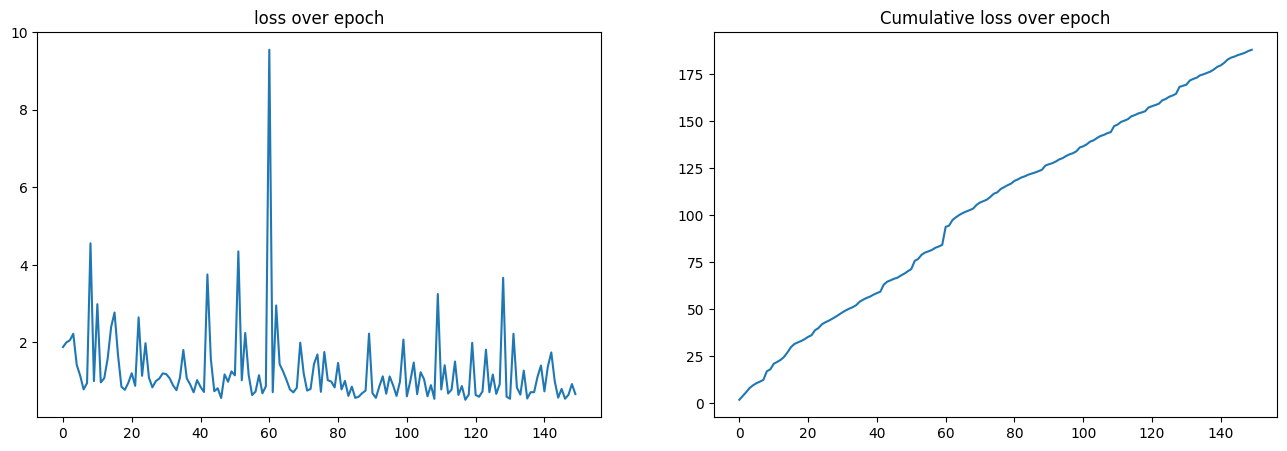

In [9]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("loss over epoch")
plt.subplot(1,2,2)
plt.plot(np.cumsum(losses))
plt.title("Cumulative loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

we have to stop after the slow down of deacrese. otherwise we might face overfitting

### out of sample comparaison 1

In [10]:
batch_size_oos_1 = 25
N_list_test_1 = [20, 40, 60, 80, 100, 120, 140, 160, 180,200,220]
T_list_test_1 = [20, 40,60, 80, 100, 120, 150, 180, 200, 220, 240, 260, 280, 300]

In [11]:
losses_value = []

In [12]:
for n in N_list_test_1:
    for t in T_list_test_1:
        lam_emp_oos_i, Q_emp_oos_i, Sigma_true_oos_i, T_t, Tmin, Tmax = next(data_generator(batch_size_oos_1, N_min=n, N_max=n, T_min=t, T_max=t))
        T_vec = torch.full((batch_size_oos_1, lam_emp_oos_i.shape[1], 1), T_t)
        N_vec = torch.full((batch_size_oos_1, lam_emp_oos_i.shape[1], 1), len(lam_emp_oos_i))

        input_seq = torch.cat([lam_emp_oos_i, N_vec,T_vec,N_vec / T_vec, Tmin, Tmax], dim=-1) 
        lam_pred_test_i = model(input_seq)
        losses_value.append(loss_function(lam_pred_test_i, Q_emp_oos_i, Sigma_true_oos_i, T_t).item())

In [13]:
# meshing
loss_grid = np.array(losses_value).reshape(len(np.array(N_list_test_1)), len(np.array(T_list_test_1)))
N_mesh, T_mesh = np.meshgrid(np.array(N_list_test_1), np.array(T_list_test_1), indexing='ij')

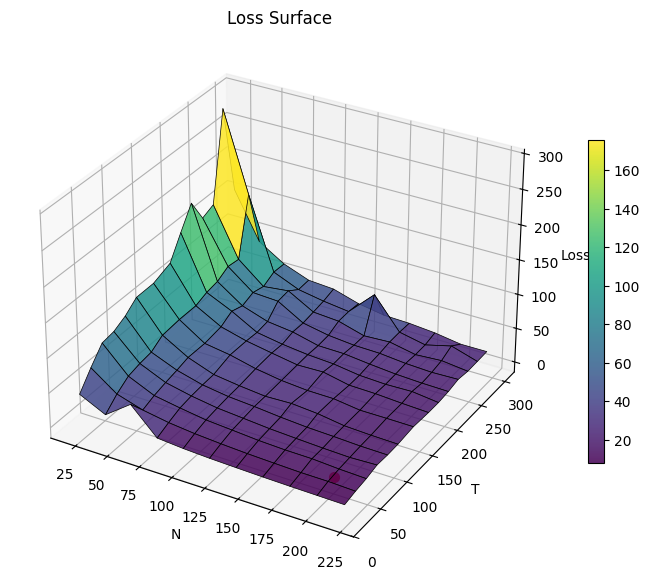

In [14]:
# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")
ax.scatter(200, 50, loss_grid[10,1], color='red', s=50)

fig.colorbar(surf, shrink=0.6)
plt.savefig('images/loss_surface.png')
plt.show()

### out of sample comparaison 2

In [15]:
batch_size_oos = 1024

In [16]:
lam_emp_cov_miss, Q_emp_cov_miss, Sigma_true, T, Tmin, Tmax, lam_emp_cov_no_miss, Q_emp_cov_no_miss, lam_QIS, Q_QIS = next(data_generator_2types(batch_size_oos, N_min=200, N_max=200, T_min=50, T_max=50))

In [17]:
T_vec = torch.full((lam_emp_cov_miss.shape[0], lam_emp_cov_miss.shape[1], 1), T)
N_vec = torch.full((lam_emp_cov_miss.shape[0], lam_emp_cov_miss.shape[1], 1), lam_emp_cov_miss.shape[1])

# Build input sequence to the GRU
input_seq_miss = torch.cat([lam_emp_cov_miss, N_vec, T_vec, N_vec / T_vec, Tmin, Tmax], dim=-1)
input_seq_no_miss = torch.cat([lam_emp_cov_no_miss, N_vec, T_vec, N_vec / T_vec, Tmin, Tmax], dim=-1)

lam_pred_miss = model(input_seq_miss)
lam_pred_no_miss = model(input_seq_no_miss)

In [18]:
lam_true_rev, _ = torch.linalg.eigh(Sigma_true)
lam_true = torch.flip(lam_true_rev, dims=[1])

Comparaison eigenvalues $\lambda$ (what matters)

In [19]:
# mse — doesn't depend on the matrix size 
mse = nn.MSELoss()

In [20]:
lam_emp_cov_no_miss.size()

torch.Size([1024, 200, 1])

In [21]:
mse_pred_lam_miss    = mse(lam_pred_miss, lam_true)
mse_pred_lam_no_miss = mse(lam_pred_no_miss, lam_true)
mse_lam_miss         = mse(lam_emp_cov_miss.squeeze(-1), lam_true)
mse_lam_no_miss      = mse(lam_emp_cov_no_miss.squeeze(-1), lam_true)
mse_lam_QIS          = mse(lam_QIS.squeeze(-1), lam_true)

# mse_noisy_test_lam
# mse_shaffer_test_lam = mse(lam_true_oos, lam_emp_1_oos.squeeze(-1))


print(f"MSE eigenvalues after miss + NN:         {mse_pred_lam_miss:.6f}")
print(f"MSE eigenvalues after no miss + NN :     {mse_pred_lam_no_miss:.6f}")
print(f"MSE eigenvalues after miss + no NN :     {mse_lam_miss:.6f}")
print(f"MSE eigenvalues after no miss  + no NN : {mse_lam_no_miss:.6f}")
print(f"MSE eigenvalues QIS :                    {mse_lam_QIS:.6f}")

# print(f"MSE Shaffer  : {mse_shaffer_test_lam:.6f}")

MSE eigenvalues after miss + NN:         3.751503
MSE eigenvalues after no miss + NN :     4.090903
MSE eigenvalues after miss + no NN :     2.429429
MSE eigenvalues after no miss  + no NN : 1.378102
MSE eigenvalues QIS :                    0.595890


Comparaison Trace (not really important)

In [22]:
trace_true            = lam_true.sum(dim=1).mean()
trace_pred_miss       = lam_pred_miss.sum(dim=1).mean()
trace_pred_no_miss    = lam_pred_no_miss.sum(dim=1).mean()
trace_emp_cov_miss    = lam_emp_cov_miss.sum(dim=1).mean()
trace_emp_cov_no_miss = lam_emp_cov_no_miss.sum(dim=1).mean()
trace_QIS         = lam_QIS.sum(dim=1).mean()

mse_tr_pred_miss       = mse(trace_pred_miss,trace_true)
mse_tr_pred_no_miss    = mse(trace_pred_no_miss,trace_true)
mse_tr_emp_cov_miss    = mse(trace_emp_cov_miss,trace_true)
mse_tr_emp_cov_no_miss = mse(trace_emp_cov_no_miss,trace_true)
mse_tr_QIS             = mse(trace_QIS,trace_true)

print(f"Real Trace : {trace_true:.4f}, miss + NN : {trace_pred_miss:.4f}, no miss + NN : {trace_pred_no_miss:.4f}, miss + no NN : {trace_emp_cov_miss:.4f}, no miss + no NN : {trace_emp_cov_no_miss:.4f}, QIS {trace_QIS}")

print(f"MSE tr after miss + NN:          {mse_tr_pred_miss:.6f}")
print(f"MSE tr after no miss + NN :      {mse_tr_pred_no_miss:.6f}")
print(f"MSE tr after miss + no NN :      {mse_tr_emp_cov_miss:.6f}")
print(f"MSE  tr after no miss  + no NN : {mse_tr_emp_cov_no_miss:.6f}")
print(f"MSE  tr after no miss  + no NN : {mse_tr_QIS:.6f}")

Real Trace : 200.4944, miss + NN : 181.3223, no miss + NN : 176.1217, miss + no NN : 200.1309, no miss + no NN : 200.1546, QIS 200.1546630859375
MSE tr after miss + NN:          367.568970
MSE tr after no miss + NN :      594.028320
MSE tr after miss + no NN :      0.132162
MSE  tr after no miss  + no NN : 0.115463
MSE  tr after no miss  + no NN : 0.115421


Comparaison matrix $\Sigma$

In [23]:
def reconstruct_cov(Q, lam):
    Lambda = torch.diag_embed(lam.squeeze(-1))
    Sigma = Q @ Lambda @ Q.transpose(1, 2)
    return Sigma

In [24]:
Sigma_pred_miss    = reconstruct_cov(Q_emp_cov_miss, lam_pred_miss)
Sigma_pred_no_miss = reconstruct_cov(Q_emp_cov_no_miss, lam_pred_no_miss)
Sigma_emp_miss     = reconstruct_cov(Q_emp_cov_miss, lam_emp_cov_miss)
Sigma_emp_no_miss  = reconstruct_cov(Q_emp_cov_no_miss, lam_emp_cov_no_miss)
Sigma_QIS          = reconstruct_cov(Q_QIS, lam_QIS)

fro_Sigma_pred_miss    = mse(Sigma_pred_miss, Sigma_true)
fro_Sigma_pred_no_miss = mse(Sigma_pred_no_miss, Sigma_true)
fro_Sigma_emp_miss     = mse(Sigma_emp_miss, Sigma_true)
fro_Sigma_emp_no_miss  = mse(Sigma_emp_no_miss, Sigma_true)
fro_Sigma_QIS          = mse(Sigma_QIS, Sigma_true)

print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss:.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss:.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss:.6f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss:.6f}")
print(f"MSE Sigma QIS :                    {fro_Sigma_QIS:.6f}")

MSE Sigma after miss + NN:         0.025339
MSE Sigma after no miss + NN :     0.024386
MSE Sigma after miss + no NN :     0.033695
MSE Sigma after no miss  + no NN : 0.021811
MSE Sigma QIS :                    0.009854


Graphique : 

In [25]:
pairs = ['Matrix', 'Trace', 'EigenValues']

pair_pred_miss    = [fro_Sigma_pred_miss.item(), mse_tr_pred_miss.item(), mse_pred_lam_miss.item()]
pair_pred_no_miss = [fro_Sigma_pred_no_miss.item(), mse_tr_pred_no_miss.item(), mse_pred_lam_no_miss.item()]
pair_emp_miss     = [fro_Sigma_emp_miss.item(), mse_tr_emp_cov_miss.item(), mse_lam_miss.item()]
pair_emp_no_miss  = [fro_Sigma_emp_no_miss.item(), mse_tr_emp_cov_no_miss.item(), mse_lam_no_miss.item()]
pair_QIS          = [fro_Sigma_QIS.item(), mse_tr_QIS.item(), mse_lam_QIS.item()]

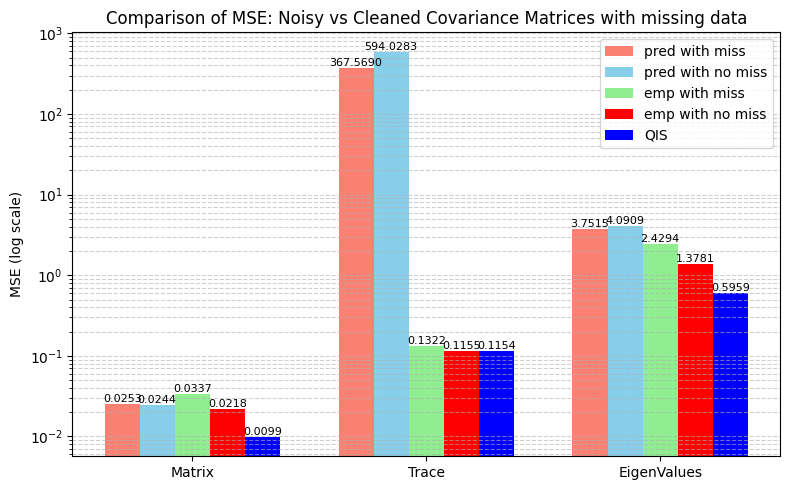

In [26]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(pairs))
width = 0.15

plt.figure(figsize=(8,5))
plt.bar(x - 2 * width, pair_pred_miss, width, label='pred with miss', color='salmon')
plt.bar(x - 1 * width, pair_pred_no_miss, width, label='pred with no miss', color='skyblue')
plt.bar(x + 0 * width, pair_emp_miss, width, label='emp with miss', color='lightgreen')
plt.bar(x + 1 * width, pair_emp_no_miss, width, label='emp with no miss', color='red')
plt.bar(x + 2 * width, pair_QIS, width, label='QIS', color='blue')


plt.yscale('log')
plt.ylabel('MSE (log scale)')
plt.xticks(x, pairs)
plt.legend()
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)

for i, (n, c, s, k, q) in enumerate(zip(pair_pred_miss, pair_pred_no_miss, pair_emp_miss, pair_emp_no_miss, pair_QIS)):
    plt.text(x[i] - 2 * width, n, f"{n:.4f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] - 1 * width, c, f"{c:.4f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + 0 * width, s, f"{s:.4f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + 1 * width, k, f"{k:.4f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + 2 * width, q, f"{q:.4f}", ha='center', va='bottom', fontsize=8)

plt.title('Comparison of MSE: Noisy vs Cleaned Covariance Matrices with missing data')
plt.tight_layout()
plt.savefig('images/results_NN_oos')
plt.show()


### Add comparaison

#### Comparaison with RIE estimator on no missing value

### Add hyperparameter selection

### Loss that minimizes the Portfolio Risk

Week timeline : 
- remove comparaison with trace : if necessary it can be normalized at the output of our network $\lambda_j * N / \sum_{i=1}^{N}\lambda_i $
- remove comparaison with eigenvalues : not meaning full as they are in another base !
- use the naiv estimator
- comparaison between GRU estimator and naiv estim
- comparaison between GRU estimator and the one from shaffer's book
- provide the GRU with x_i = {l_i, T} => find a way to give it the mask without making it dependant on some size

To be added
- we could add : eigenvalues monotonically decreasing
- hyperparameter tuning
- k split cross validation
- try stochastic gradient descent

To be written in the report
- write abt RIE and that we do smt simular
- write abt GRU and how it helps us here
- a problem is that eigenVector are noisy